# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

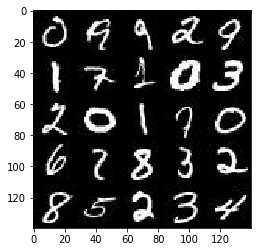

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

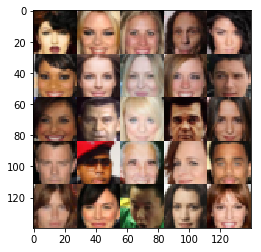

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Implement Function
    real_input = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels))
    Z = tf.placeholder(tf.float32,(None,z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_input, Z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Implement Function
    # following dcgan notebook 
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Implement Function
    reuse = not is_train
    with tf.variable_scope('generator',reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Implement Function
    # following the dcgan tutorial
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Implement Function
    # following the dcgan tutorial
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # following the dcgan tutorial
    # Build Model
    if data_image_mode == "RGB": image_channels = 3
    else: image_channels = 1
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # note that real images are from -0.5 to 0.5, but the generator images are from -1 to 1
                # we have to scale the real images
                batch_images *= 2
                
                # Train Model
                # following the dcgan tutorial
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 200 == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.5505... Generator Loss: 0.0297
Epoch 1/2... Discriminator Loss: 0.3593... Generator Loss: 2.1411
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 0.9990
Epoch 1/2... Discriminator Loss: 0.1367... Generator Loss: 5.0417


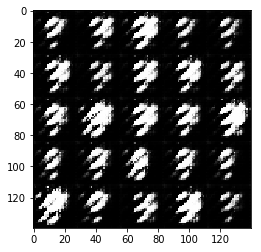

Epoch 1/2... Discriminator Loss: 0.5448... Generator Loss: 8.1283
Epoch 1/2... Discriminator Loss: 1.5071... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 5.4598
Epoch 1/2... Discriminator Loss: 1.4972... Generator Loss: 0.3986


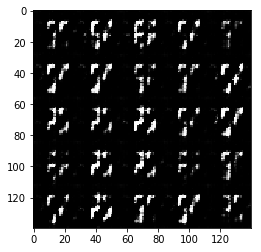

Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 6.2166
Epoch 1/2... Discriminator Loss: 0.3550... Generator Loss: 2.1996
Epoch 1/2... Discriminator Loss: 0.4849... Generator Loss: 1.8384
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 1.6140


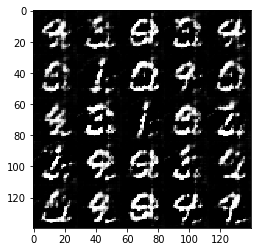

Epoch 1/2... Discriminator Loss: 0.4271... Generator Loss: 2.3342
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 0.3918... Generator Loss: 2.6359
Epoch 1/2... Discriminator Loss: 0.9455... Generator Loss: 3.9666


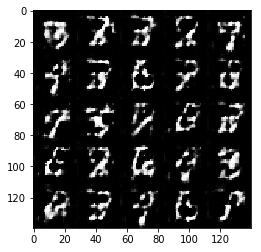

Epoch 1/2... Discriminator Loss: 0.5065... Generator Loss: 4.1280
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 1.6391
Epoch 1/2... Discriminator Loss: 0.3431... Generator Loss: 2.8671
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 1.7016


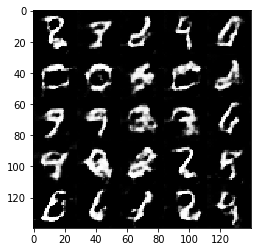

Epoch 1/2... Discriminator Loss: 1.4219... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 0.8970
Epoch 1/2... Discriminator Loss: 0.7361... Generator Loss: 1.3983
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 1.2000


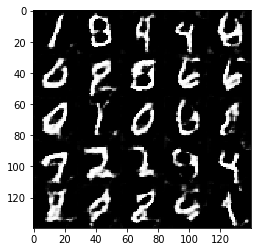

Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 0.8631
Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.5438


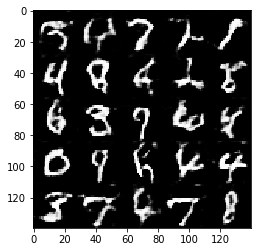

Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 0.4704
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 1.5261
Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.7344... Generator Loss: 0.3492


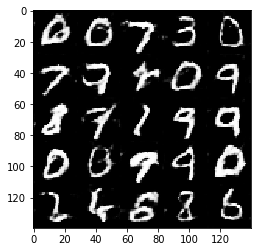

Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 1.7221... Generator Loss: 0.3723
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 1.0389
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 0.8458


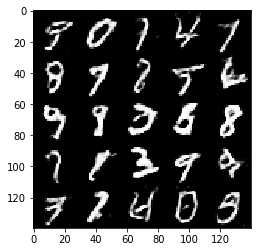

Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 1.6743
Epoch 2/2... Discriminator Loss: 1.3342... Generator Loss: 0.4546
Epoch 2/2... Discriminator Loss: 1.6403... Generator Loss: 0.3095
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 1.7335


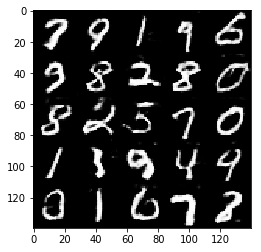

Epoch 2/2... Discriminator Loss: 1.4985... Generator Loss: 0.3761
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 0.7315
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.4129
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.6804


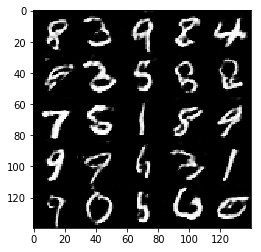

Epoch 2/2... Discriminator Loss: 1.4521... Generator Loss: 0.3723
Epoch 2/2... Discriminator Loss: 0.9027... Generator Loss: 1.8606
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 1.4854
Epoch 2/2... Discriminator Loss: 1.0084... Generator Loss: 0.8858


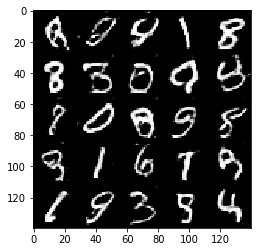

Epoch 2/2... Discriminator Loss: 0.6686... Generator Loss: 1.6374
Epoch 2/2... Discriminator Loss: 0.9779... Generator Loss: 1.8946
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 0.7342... Generator Loss: 1.3817


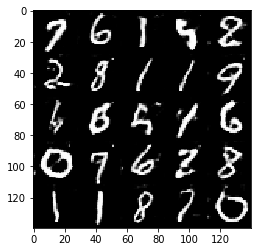

Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 1.4306... Generator Loss: 0.4281
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 0.7511
Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 0.4428


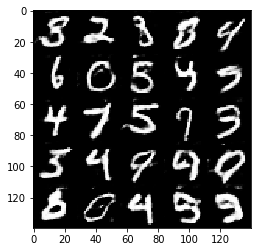

Epoch 2/2... Discriminator Loss: 2.4744... Generator Loss: 3.5166
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 0.8980
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 1.2379... Generator Loss: 0.5452


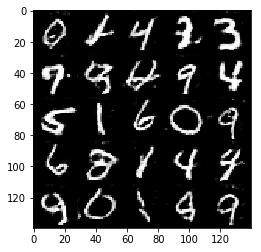

Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 0.9373
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.4604
Epoch 2/2... Discriminator Loss: 1.5106... Generator Loss: 0.3698
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 0.7394


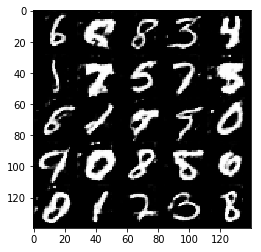

Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 0.4837
Epoch 2/2... Discriminator Loss: 0.8180... Generator Loss: 1.0135
Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 2.0407
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 1.1278


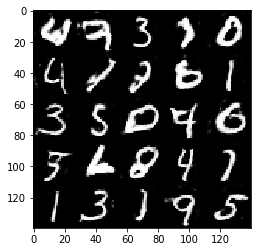

Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 3.0091
Epoch 2/2... Discriminator Loss: 0.5169... Generator Loss: 1.3165
Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 1.5050
Epoch 2/2... Discriminator Loss: 2.0901... Generator Loss: 0.2141


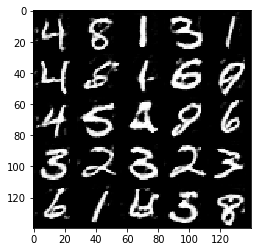

Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 1.0616
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 2.7526
Epoch 2/2... Discriminator Loss: 1.6413... Generator Loss: 2.8394


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0025... Generator Loss: 0.3076
Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 5.3420
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 2.1282
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 3.0237


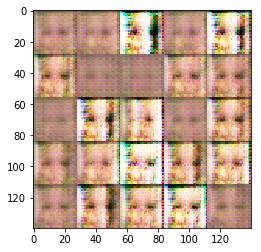

Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 1.4550
Epoch 1/1... Discriminator Loss: 0.1272... Generator Loss: 3.9606
Epoch 1/1... Discriminator Loss: 0.0625... Generator Loss: 3.3402


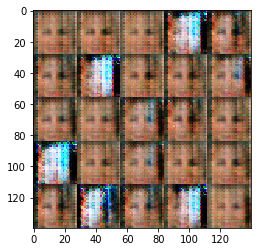

Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.8206
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 5.1652
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.1772


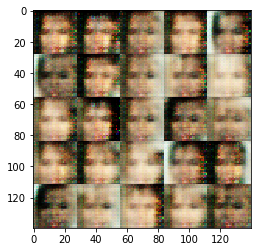

Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 2.8138
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 2.4329... Generator Loss: 0.2051
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 1.0734


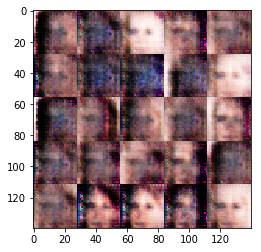

Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.6184... Generator Loss: 0.4435
Epoch 1/1... Discriminator Loss: 0.6259... Generator Loss: 2.6096
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 1.3767


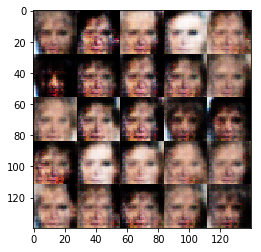

Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.7696
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 2.4050
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 1.9901
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.7838


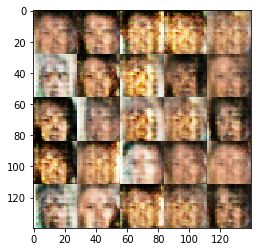

Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 2.4114
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 2.2766
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.1389
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 2.1254


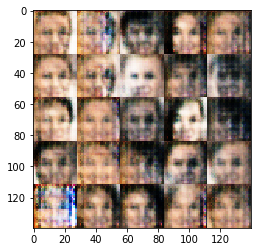

Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 3.6627
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 3.4457
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.9622
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 2.9630


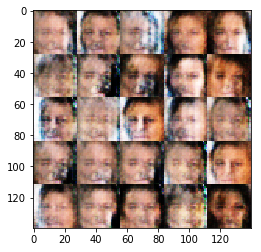

Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 1.8610
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 2.0335... Generator Loss: 0.2030
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 1.5968


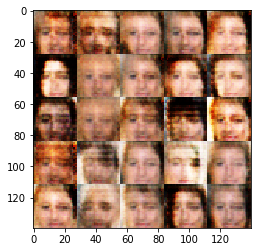

Epoch 1/1... Discriminator Loss: 0.7017... Generator Loss: 2.8349
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.1627
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.7478


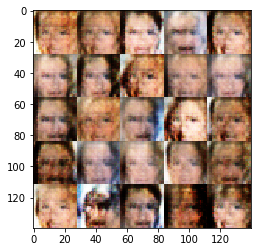

Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 1.5555
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 3.1084
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 2.0491


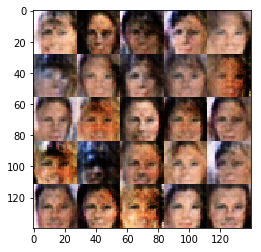

Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.5967
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 2.6107


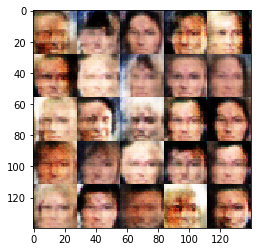

Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 1.5693
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.4992


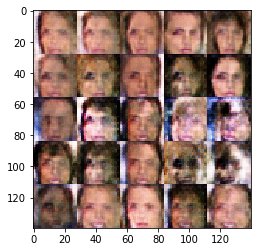

Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.6077


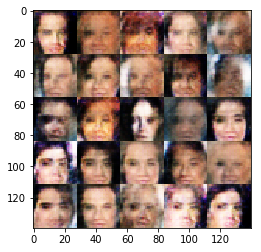

Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 1.4590


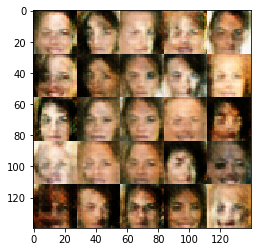

Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 1.6165
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 0.9503


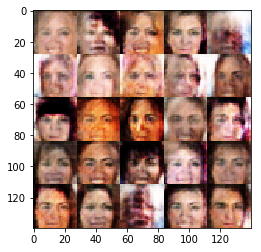

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 0.9727


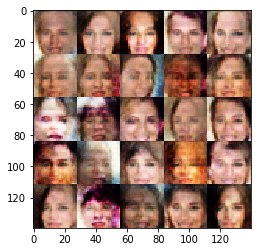

Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.6113
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 2.6693
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 0.9004


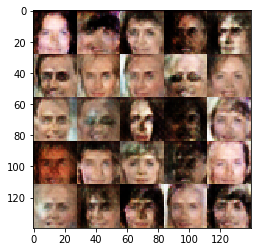

Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 2.3613
Epoch 1/1... Discriminator Loss: 0.7061... Generator Loss: 2.3788


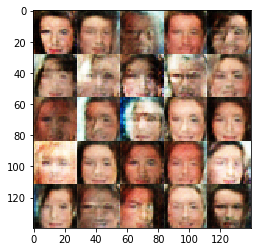

Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.4032
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 2.3490


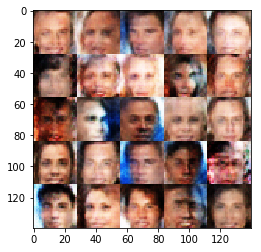

Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.6755
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 1.9830... Generator Loss: 0.2509
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 0.9536


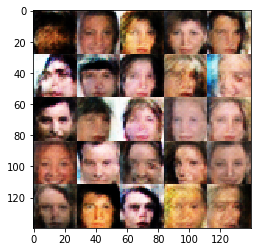

Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 2.2500
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 1.8528


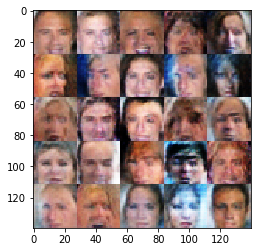

Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 2.0171
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.7302


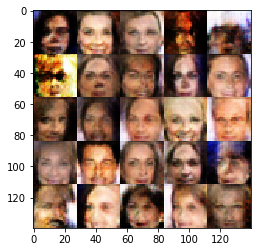

Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 0.6919... Generator Loss: 1.7120
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.4701


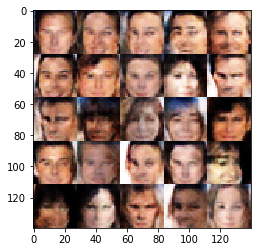

Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.4112
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 1.9137
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 0.9254


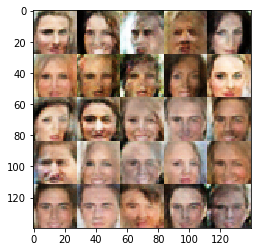

Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.9204


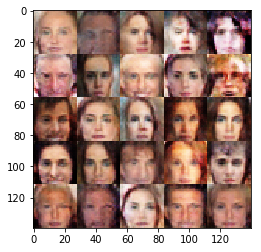

Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.6628... Generator Loss: 0.3388


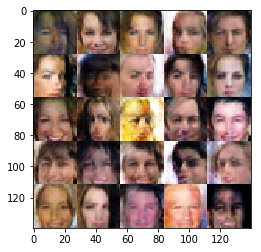

Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.2248
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.4965
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 0.2878


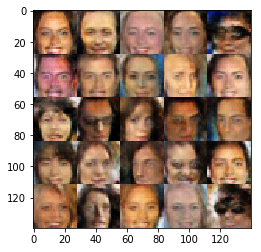

Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 1.2510
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.1206


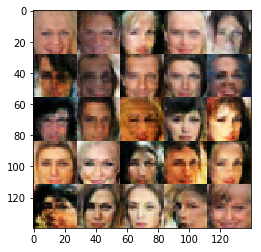

Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.4200


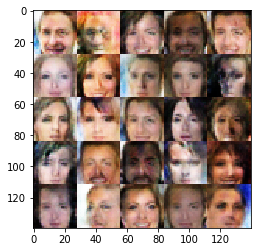

Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.0789


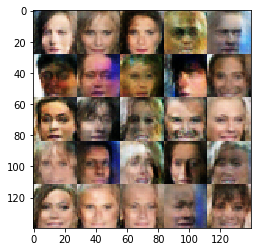

Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.4055


In [13]:
batch_size = 32
z_dim = 100 
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.